In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, rerank_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import average_precision_for_user, f1_score
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [2]:
ALGORITHMS = ['cbf', 'item-item', 'mf', 'perbias', 'user-user']
ALGORITHMS_TO_IMPROVE = ['cbf', 'item-item', 'mf']

SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category', 'F1']

set_ratings(read_ratings_from_file())
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  f1_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    
    if algorithm in ALGORITHMS_TO_IMPROVE:
        top_n = rerank_top_n(user_id, top_n, 3)
    
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(average_precision_for_user(top_n, user_id))
    f1_values.append(f1_score(top_n, user_id))
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['F1'][algorithm] = calculate_statistics(f1_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['F1'] = pd.concat([results['F1'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

In [3]:
colors= ['g', 'b', 'r', 'y', 'purple']
labels = ['Content Based Filtering', 'Item-Item CF', 'Matrix Factorization', 'Personalized Bias', 'User-User CB']

width = 10 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

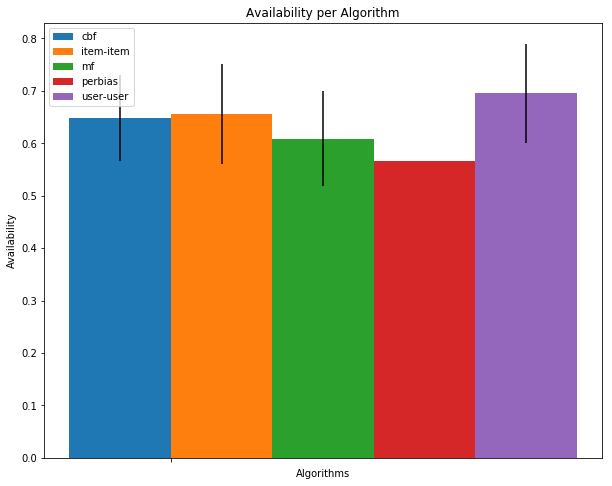

In [4]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [5]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.533301,0.591300,0.656952,0.708917,0.800093,0.835533,0.648720,0.450466,8.170369e-02
item-item,0.532759,0.578999,0.661119,0.725416,0.838894,0.841608,0.655707,0.437765,9.457198e-02
mf,0.486395,0.548542,0.609989,0.672035,0.827135,0.838824,0.608982,0.411734,9.015457e-02
perbias,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,2.220446e-16
user-user,0.567862,0.624114,0.688028,0.761760,0.908394,0.918805,0.695152,0.500692,9.481942e-02


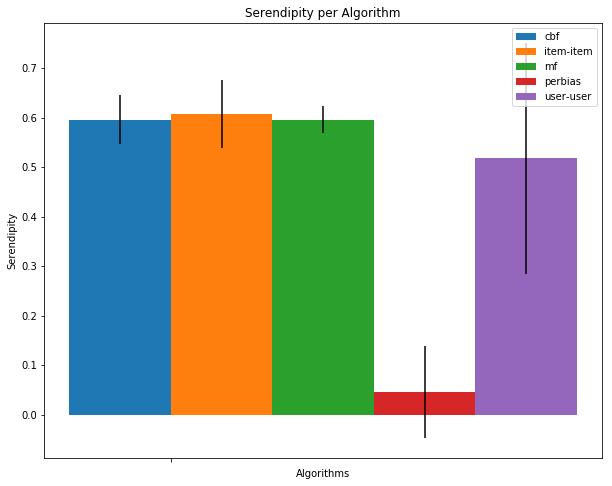

In [6]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [7]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.6,0.6,0.6,0.60,0.602,0.8,0.596,0.2,0.048826
item-item,0.6,0.6,0.6,0.60,1.000,1.0,0.608,0.4,0.068819
mf,0.6,0.6,0.6,0.60,0.600,0.6,0.596,0.4,0.028000
perbias,0.0,0.0,0.0,0.00,0.400,0.4,0.046,0.0,0.093188
user-user,0.2,0.4,0.6,0.65,1.000,1.0,0.518,0.0,0.233401


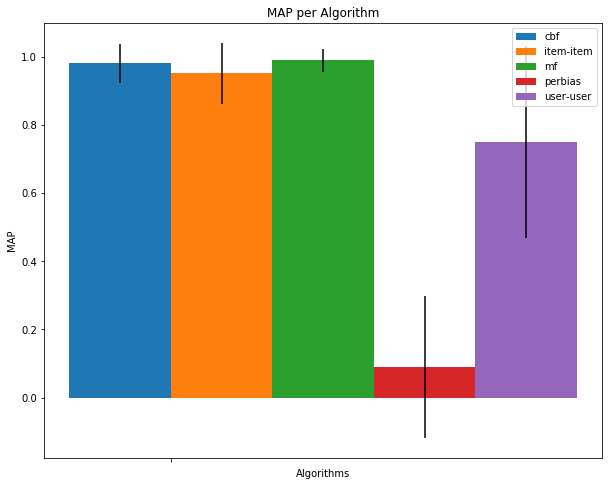

In [8]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [9]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.916667,1.000000,1.00,1.0,1.0,1.0,0.980333,0.533333,0.057367
item-item,0.805556,0.916667,1.00,1.0,1.0,1.0,0.950778,0.588889,0.090103
mf,0.991667,1.000000,1.00,1.0,1.0,1.0,0.989167,0.866667,0.033448
perbias,0.000000,0.000000,0.00,0.0,1.0,1.0,0.090000,0.000000,0.208527
user-user,0.332500,0.588889,0.85,1.0,1.0,1.0,0.749278,0.000000,0.281404


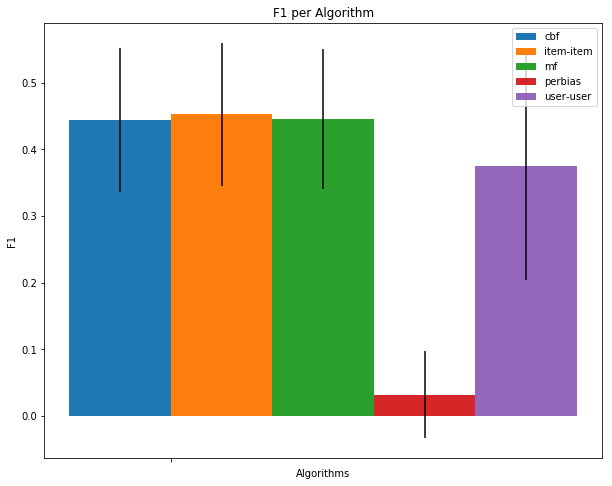

In [10]:
metric = results['F1']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('F1')
ax.set_title('F1 per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()


In [11]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.298571,0.369485,0.445055,0.500000,0.666667,0.666667,0.443804,0.193548,0.107626
item-item,0.314211,0.375000,0.461538,0.511364,0.666667,0.666667,0.452436,0.193548,0.107457
mf,0.314211,0.375000,0.461538,0.500000,0.666667,0.666667,0.444994,0.193548,0.105023
perbias,0.000000,0.000000,0.000000,0.000000,0.222353,0.235294,0.032078,0.000000,0.064881
user-user,0.153846,0.246324,0.375000,0.500000,0.728000,0.800000,0.374980,0.000000,0.171491


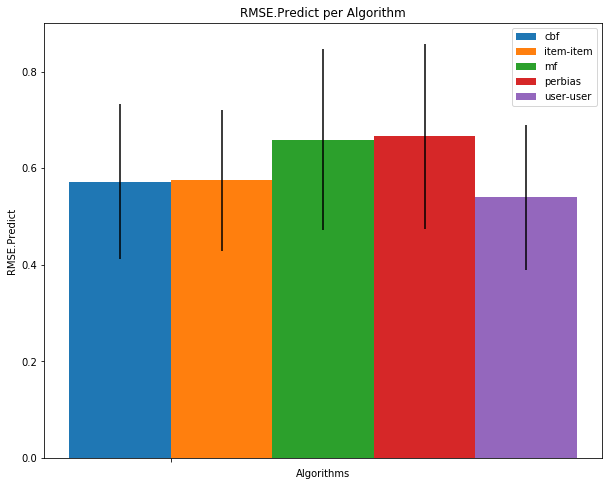

In [12]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [13]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.371323,0.458708,0.565546,0.665676,0.989574,1.017527,0.572387,0.266683,0.161299
item-item,0.393176,0.488066,0.549393,0.634057,0.992785,1.028632,0.574672,0.335113,0.146474
mf,0.428535,0.524264,0.638710,0.746580,1.133340,1.258139,0.659029,0.311749,0.187732
perbias,0.422884,0.530699,0.640388,0.751699,1.134227,1.389332,0.666273,0.339838,0.191875
user-user,0.379496,0.451870,0.521396,0.608613,0.961865,1.027937,0.539678,0.000000,0.150756


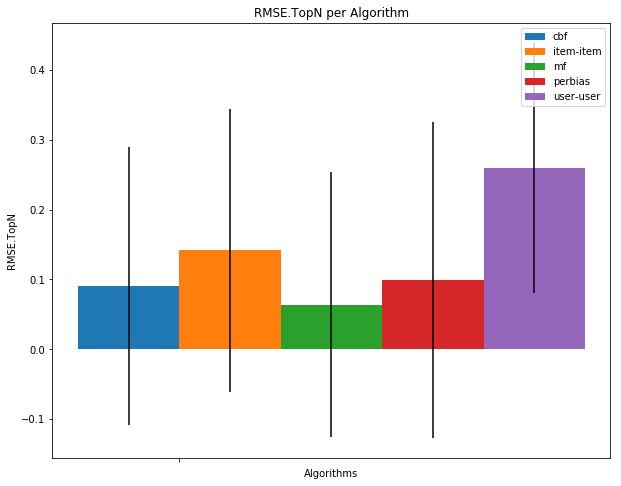

In [14]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [15]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.051779,0.816497,0.816497,0.090506,0.0,0.199576
item-item,0.000000,0.000000,0.066134,0.219858,0.816497,0.816497,0.141965,0.0,0.202538
mf,0.000000,0.000000,0.000000,0.000000,0.816497,0.816497,0.064029,0.0,0.189595
perbias,0.000000,0.000000,0.000000,0.005937,0.993975,1.013406,0.098952,0.0,0.225976
user-user,0.055927,0.117116,0.230005,0.399643,0.680138,0.931245,0.259641,0.0,0.179276


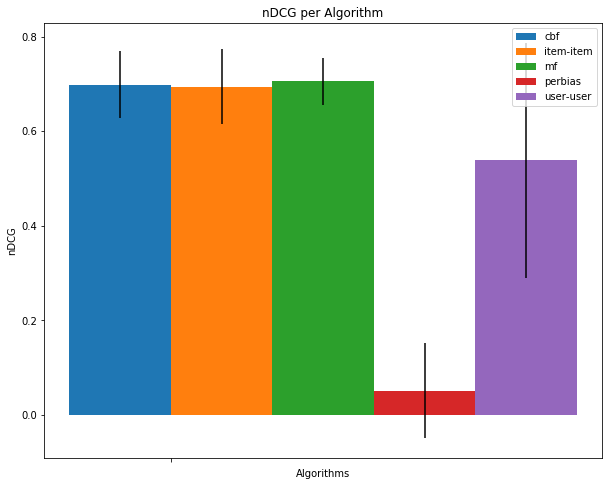

In [16]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [17]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.629398,0.726229,0.726229,0.726229,0.727439,0.847267,0.698257,0.242076,0.070134
item-item,0.605191,0.636886,0.726229,0.726229,1.000000,1.000000,0.694245,0.394809,0.079019
mf,0.629398,0.726229,0.726229,0.726229,0.726229,0.726229,0.705300,0.484153,0.049691
perbias,0.000000,0.000000,0.000000,0.024208,0.395219,0.435737,0.051781,0.000000,0.100283
user-user,0.242076,0.363114,0.515847,0.732568,1.000000,1.000000,0.538416,0.000000,0.248525


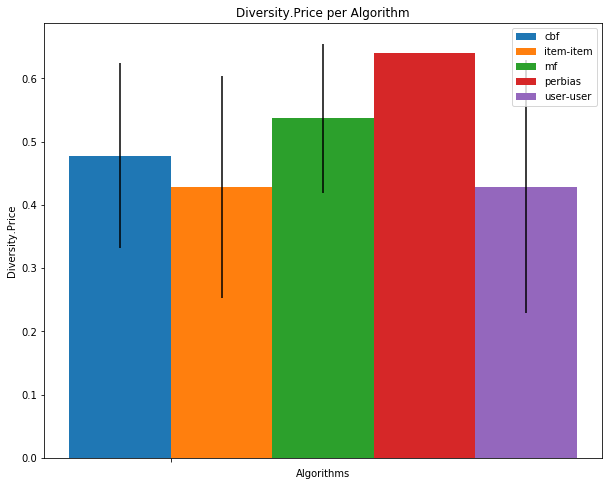

In [18]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [19]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.240,0.40,0.48,0.56,0.7200,0.72,0.4776,0.00,1.464044e-01
item-item,0.240,0.32,0.48,0.56,0.6408,0.72,0.4280,0.00,1.757726e-01
mf,0.392,0.48,0.56,0.64,0.7200,0.72,0.5368,0.24,1.182783e-01
perbias,0.640,0.64,0.64,0.64,0.6400,0.64,0.6400,0.64,1.110223e-16
user-user,0.160,0.32,0.48,0.56,0.7200,0.72,0.4288,0.00,2.000064e-01


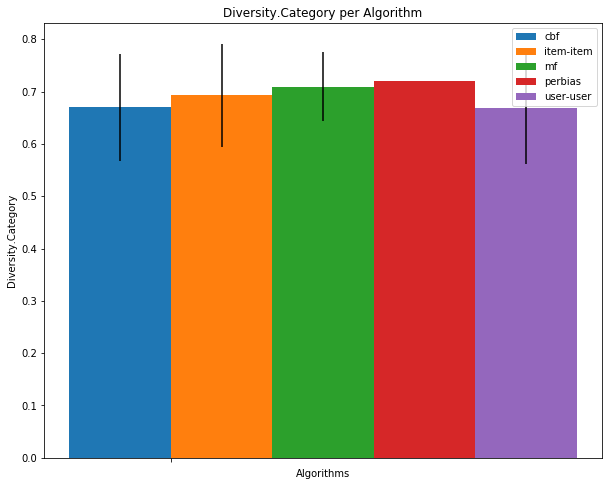

In [20]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [21]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.56,0.64,0.72,0.72,0.80,0.80,0.6696,0.32,1.016063e-01
item-item,0.56,0.64,0.72,0.72,0.80,0.80,0.6928,0.32,9.877328e-02
mf,0.64,0.72,0.72,0.72,0.80,0.80,0.7096,0.56,6.563414e-02
perbias,0.72,0.72,0.72,0.72,0.72,0.72,0.7200,0.72,1.110223e-16
user-user,0.56,0.56,0.72,0.72,0.80,0.80,0.6688,0.32,1.082338e-01


In [22]:
pd.DataFrame.from_dict(results['Coverage.Item'])

,cbf,item-item,mf,perbias,user-user
0,0.57,0.665,0.555,0.025,0.755


In [23]:
pd.DataFrame.from_dict(results['Coverage.User'])

,cbf,item-item,mf,perbias,user-user
0,1.0,1.0,1.0,1.0,1.0
